In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import tf2lib as tl
import tf2gan as gan
import DLlib as dl
import pylib as py
import wflib as wf
import data

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tqdm
import h5py
import xlsxwriter
import ipywidgets as widgets
from itertools import cycle

In [2]:
############################################################
############### DIRECTORIES AND FILENAMES ##################
############################################################
# dataset_dir = '../MATLAB/waterFatSignalPhantom/data_out/'
dataset_dir = '../../OneDrive - Universidad Católica de Chile/Documents/MATLAB/waterFatSignalPhantom/data_out/'
dataset_hdf5_1 = 'phantom_SNR10.hdf5'

############################################################
################### LOAD DATASET 1 #########################
############################################################
acqs_1, out_maps_1 = data.load_hdf5(dataset_dir,dataset_hdf5_1,MEBCRN=True)

print('Num. Elements- DS1:', len(acqs_1))

Num. Elements- DS1: 1


In [3]:
############################################################
################# DATASET PARTITIONS #######################
############################################################

testX   = acqs_1

testY   = out_maps_1

# Overall dataset statistics
len_dataset,ne,hgt,wdt,n_ch = np.shape(testX)
_,n_out,_,_,_ = np.shape(testY)
r2_sc,fm_sc = 200,300

print('Acquisition Dimensions:', hgt,wdt)
print('Echoes:',ne)
print('Output Maps:',n_out)

# Input and output dimensions (testing data)
print('Testing input shape:',testX.shape)
print('Testing output shape:',testY.shape)

A_B_dataset_test = tf.data.Dataset.from_tensor_slices((testX,testY))
A_B_dataset_test.batch(1)
test_iter = cycle(A_B_dataset_test)

Acquisition Dimensions: 192 192
Echoes: 6
Output Maps: 3
Testing input shape: (1, 6, 192, 192, 2)
Testing output shape: (1, 3, 192, 192, 2)


In [4]:
model_sel = widgets.Dropdown(
    options=['U-Net', 'MDWF-Net', 'VET-Net','AI-DEAL'],
    value='AI-DEAL',
    description='Model:',
    disabled=False,
)
model_sel

Dropdown(description='Model:', index=3, options=('U-Net', 'MDWF-Net', 'VET-Net', 'AI-DEAL'), value='AI-DEAL')

In [5]:
data_ratio_sel = widgets.Dropdown(
    options=[0,3,9,15,149],
    value=149,
    description='Real subjects considered for training:',
    disabled=False,
)
data_ratio_sel

Dropdown(description='Real subjects considered for training:', index=4, options=(0, 3, 9, 15, 149), value=149)

In [6]:
ech_sel = widgets.IntSlider(
    value=6,
    min=2,
    max=12,
    step=1,
    description='Num. Echoes:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
ech_sel

IntSlider(value=6, continuous_update=False, description='Num. Echoes:', max=12, min=2)

In [7]:
remove_ech1 = widgets.Checkbox(
    value=False,
    description='Remove first echo',
)
remove_ech1

Checkbox(value=False, description='Remove first echo')

In [8]:
if model_sel.value == 'U-Net':
    if ech_sel.value == 6:
        if data_ratio_sel.value == 149:
            model_fn = 'Sup-202'
        elif data_ratio_sel.value == 15:
            model_fn = 'Sup-403'
        elif data_ratio_sel.value == 9:
            model_fn = 'Sup-402'
        elif data_ratio_sel.value == 3:
            model_fn = 'Sup-401'
        elif data_ratio_sel.value == 0:
            model_fn = 'Sup-400'
    elif ech_sel.value == 3:
        model_fn = 'Sup-203'
    experiment_dir = py.join('output',model_fn)
    args = py.args_from_yaml(py.join(experiment_dir, 'settings.yml'))
    G_A2B = dl.UNet(input_shape=(None,None,2*ech_sel.value), n_out=2, filters=args.n_G_filters,output_activation='relu')
    checkpoint = tl.Checkpoint(dict(G_A2B=G_A2B), py.join(experiment_dir, 'checkpoints'))
elif model_sel.value == 'MDWF-Net':
    if ech_sel.value == 6:
        if data_ratio_sel.value == 149:
            model_fn = 'Sup-204'
        elif data_ratio_sel.value == 15:
            model_fn = 'Sup-404'
        elif data_ratio_sel.value == 9:
            model_fn = 'Sup-405'
        elif data_ratio_sel.value == 3:
            model_fn = 'Sup-406'
        elif data_ratio_sel.value == 0:
            model_fn = 'Sup-407'
    elif ech_sel.value == 3:
        model_fn = 'Sup-205'
    experiment_dir = py.join('output',model_fn)
    args = py.args_from_yaml(py.join(experiment_dir, 'settings.yml'))
    G_A2B = dl.MDWF_Generator(input_shape=(None,None,2*ech_sel.value), filters=args.n_G_filters, 
                              WF_self_attention=args.D1_SelfAttention, R2_self_attention=args.D2_SelfAttention,
                              FM_self_attention=args.D3_SelfAttention)
    checkpoint = tl.Checkpoint(dict(G_A2B=G_A2B), py.join(experiment_dir, 'checkpoints'))
elif model_sel.value == 'VET-Net':
    experiment_dir = py.join('output','TEaug-300')
    args = py.args_from_yaml(py.join(experiment_dir, 'settings.yml'))
    G_A2B = dl.PM_Generator(input_shape=(None,None,None,2), te_input=True, te_shape=(None,), filters=args.n_G_filters)
    checkpoint = tl.Checkpoint(dict(G_A2B=G_A2B), py.join(experiment_dir, 'checkpoints'))
elif model_sel.value == 'AI-DEAL':
    experiment_dir = py.join('output','Unsup-110')
    args = py.args_from_yaml(py.join(experiment_dir, 'settings.yml'))
    G_A2B = dl.UNet(input_shape=(None,None,None,2), bayesian=True, ME_layer=True, filters=args.n_G_filters,
                    self_attention=args.D1_SelfAttention)
    G_A2R2= dl.UNet(input_shape=(None,None,None,1), bayesian=True, ME_layer=True, filters=args.n_G_filters,
                    output_activation='sigmoid', self_attention=args.D2_SelfAttention)
    checkpoint = tl.Checkpoint(dict(G_A2B=G_A2B, G_A2R2=G_A2R2), py.join(experiment_dir, 'checkpoints'))

try:  # restore checkpoint including the epoch counter
    checkpoint.restore().assert_existing_objects_matched()
except Exception as e:
    print(e)

In [9]:
# Sample function
@tf.function
def sample(A, TE):
    A_abs = tf.math.sqrt(tf.reduce_sum(tf.square(A), axis=-1, keepdims=True))
    A_msk = tf.reduce_mean(A_abs, axis=1, keepdims=True)
    A2B_msk = tf.concat([A_msk,A_msk], axis=-1)
    if A.shape[1] > ech_sel.value:
        A = A[:,:ech_sel.value,...]
    if model_sel.value == 'U-Net':
        A_pf = data.A_from_MEBCRN(A) # CHANGE TO NON-MEBCRN FORMAT
        A2B_WF_abs = G_A2B(A_pf, training=False)
        A2B_WF_abs = tf.expand_dims(A2B_WF_abs, axis=1)
        A2B_WF_abs = tf.transpose(A2B_WF_abs, perm=[0,4,2,3,1])
        A2B_WF = tf.concat([A2B_WF_abs, tf.zeros_like(A2B_WF_abs)], axis=-1)
        A2B = tf.concat([A2B_WF, tf.zeros_like(A2B_WF[:,:1,...])], axis=1)
        A2B = tf.where(A2B_msk>=5e-3, A2B, 0.0)
        A2B_var = None
    elif model_sel.value == 'MDWF-Net':
        A_pf = data.A_from_MEBCRN(A) # CHANGE TO NON-MEBCRN FORMAT
        A2B = G_A2B(A_pf, training=False)
        A2B = tf.expand_dims(A2B, axis=1)
        A2B_PM = A2B[...,-1:-3:-1]
        A2B_WF_abs = A2B[...,:2]
        A2B_WF_abs = tf.transpose(A2B_WF_abs, perm=[0,4,2,3,1])
        A2B_WF = tf.concat([A2B_WF_abs, tf.zeros_like(A2B_WF_abs)], axis=-1)
        A2B = tf.concat([A2B_WF, A2B_PM], axis=1)
        A2B = tf.where(A2B_msk>=5e-3, A2B, 0.0)
        A2B_var = None
    elif model_sel.value == 'VET-Net':
        A2B_PM = G_A2B([A,TE], training=False) #[:,:ech_sel.value,...]
        A2B_PM = tf.where(A2B_msk>=5e-3, A2B_PM, 0.0)
        if remove_ech1.value:
            A2B_WF = wf.get_rho(A[:,1:,...], A2B_PM, te=TE[:,1:,...])
        else:
            A2B_WF = wf.get_rho(A, A2B_PM, te=TE)
        A2B = tf.concat([A2B_WF, A2B_PM], axis=1)
        A2B_var = None
    elif model_sel.value == 'AI-DEAL':
        A2B_msk = tf.concat([A2B_msk,A2B_msk,A2B_msk], axis=1)
        A2B_var_msk = tf.concat([A2B_msk,A2B_msk,A2B_msk,A2B_msk,A2B_msk], axis=1)
        if remove_ech1.value:
            A2B_FM = G_A2B(A[:,1:,...], training=False)
        else:
            A2B_FM = G_A2B(A, training=False)
        A2B_R2 = G_A2R2(A_abs, training=False)
        A2B_PM = tf.concat([A2B_FM.mean(),A2B_R2.mean()],axis=-1)
        if remove_ech1.value:
            A2B_WF, A2B_WF_var = wf.PDFF_uncertainty(A[:,1:,...], A2B_FM, A2B_R2, te=TE[:,1:,...], rem_R2=False)
        else:
            A2B_WF, A2B_WF_var = wf.PDFF_uncertainty(A, A2B_FM, A2B_R2, te=TE, rem_R2=False)
        A2B_WF_var = tf.concat([A2B_WF_var,tf.zeros_like(A2B_WF_var)],axis=-1)
        A2B_PM_var = tf.concat([A2B_FM.variance(),A2B_R2.variance()],axis=-1)
        A2B_var = tf.concat([A2B_WF_var,A2B_PM_var], axis=1)
        if A.shape[1] >= A2B_var.shape[1]:
            A2B_var = tf.where(tf.abs(A[:,:5,...])>=5e-3, A2B_var, 1e-10)
        else:
            A_aux = tf.concat([A,A],axis=1)
            A2B_var = tf.where(A2B_msk>=5e-3, A2B_var, 1e-10)
        A2B = tf.concat([A2B_WF, A2B_PM], axis=1)
        A2B = tf.where(A2B_msk>=5e-3, A2B, 0.0)
    return A2B, A2B_var

def test(A, TE=None):
    A2B, A2B_var = sample(A, TE)
    return A2B, A2B_var

In [10]:
A, B = next(test_iter)
A = tf.expand_dims(A,axis=0)
B = tf.expand_dims(B,axis=0)

te = wf.gen_TEvar(ne, orig=True)
A2B, A2B_var = test(A,TE=te)

C:\Users\jpmen\AppData\Local\Temp\ipykernel_22112\2923699834.py:7: RuntimeWarning: invalid value encountered in divide
  PDFF_res = np.where(f_aux >= w_aux, f_aux/wf_aux, 1-(w_aux/wf_aux))
C:\Users\jpmen\AppData\Local\Temp\ipykernel_22112\2923699834.py:13: RuntimeWarning: invalid value encountered in divide
  PDFF_gt = fn_aux/(wn_aux+fn_aux)


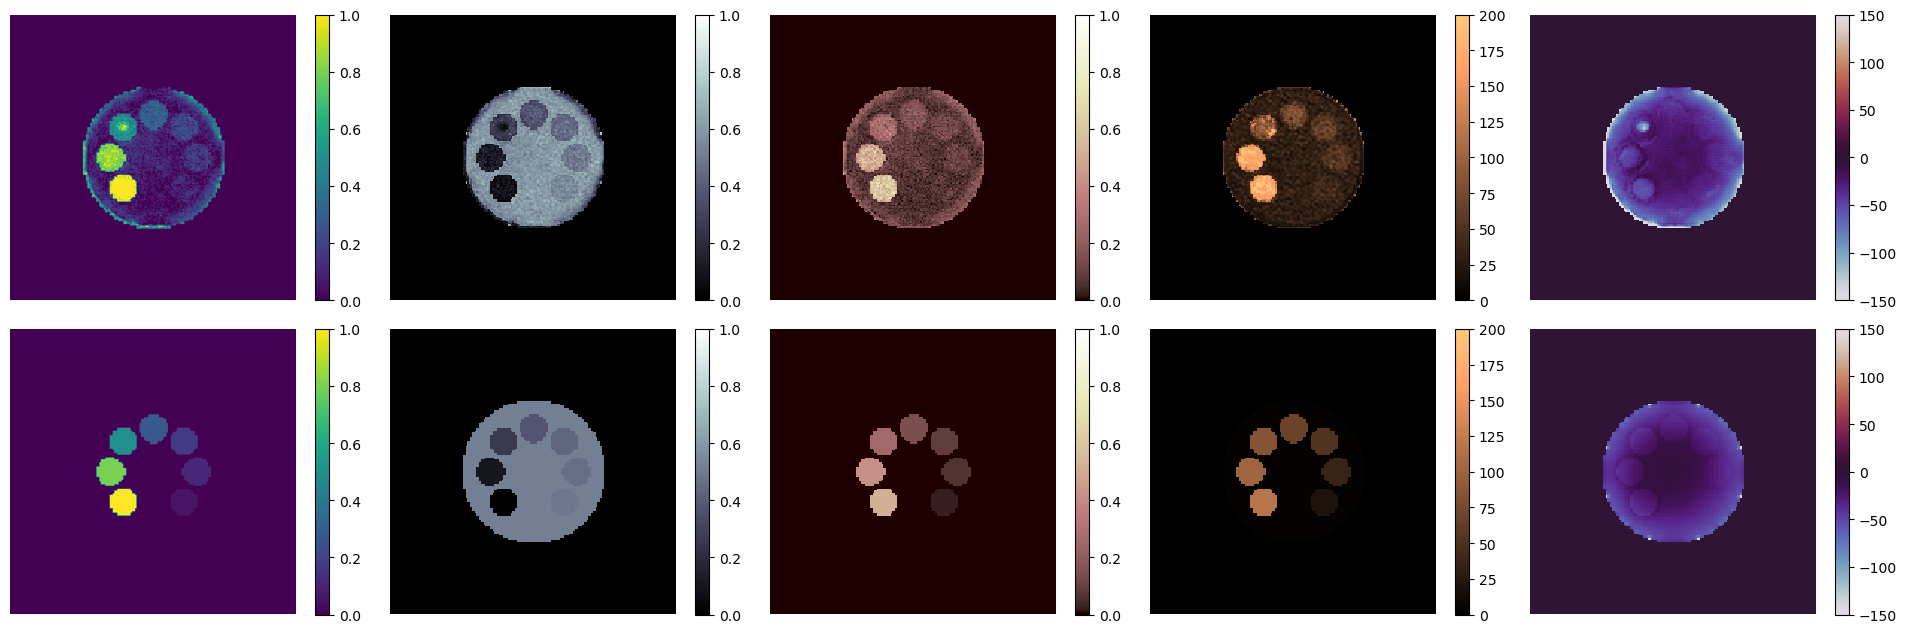

In [11]:
fig, ((ax0,ax1,ax2,ax3,ax4),(ax00,ax5,ax6,ax7,ax8))=plt.subplots(figsize=(19, 6),
                                                        nrows=2, ncols=5)
# Ground-Truth PDFF
w_aux = np.squeeze(tf.abs(tf.complex(A2B[:,0,:,:,0],A2B[:,0,:,:,1])))
f_aux = np.squeeze(tf.abs(tf.complex(A2B[:,1,:,:,0],A2B[:,1,:,:,1])))
wf_aux = np.squeeze(tf.abs(tf.complex(A2B[:,0,:,:,0]+A2B[:,1,:,:,0],A2B[:,0,:,:,1]+A2B[:,1,:,:,1])))
PDFF_res = np.where(f_aux >= w_aux, f_aux/wf_aux, 1-(w_aux/wf_aux))
PDFF_res[np.isnan(PDFF_res)] = 0.0

# Model Measured PDFF
wn_aux = np.squeeze(np.abs(tf.complex(B[:,0,:,:,0],B[:,0,:,:,1])))
fn_aux = np.squeeze(np.abs(tf.complex(B[:,1,:,:,0],B[:,1,:,:,1])))
PDFF_gt = fn_aux/(wn_aux+fn_aux)
PDFF_gt[np.isnan(PDFF_gt)] = 0.0

# Ground truth in the first row
FF_ok = ax0.imshow(PDFF_res, vmin=0, vmax=1)
fig.colorbar(FF_ok, ax=ax0)
ax0.axis('off')

W_ok = ax1.imshow(w_aux, cmap='bone',
                  interpolation='none', vmin=0, vmax=1)
fig.colorbar(W_ok, ax=ax1)
ax1.axis('off')

F_ok = ax2.imshow(f_aux, cmap='pink',
                  interpolation='none', vmin=0, vmax=1)
fig.colorbar(F_ok, ax=ax2)
ax2.axis('off')

r2_aux = np.squeeze(A2B[:,2,:,:,1])*r2_sc
r2_ok = ax3.imshow(r2_aux, cmap='copper',
                   interpolation='none', vmin=0, vmax=r2_sc)
fig.colorbar(r2_ok, ax=ax3)
ax3.axis('off')

field_aux = np.squeeze(A2B[:,2,:,:,0])*fm_sc
field_ok = ax4.imshow(field_aux, cmap='twilight',
                      interpolation='none', vmin=-fm_sc/2, vmax=fm_sc/2)
fig.colorbar(field_ok, ax=ax4)
ax4.axis('off')

# Computed maps in the second row
FF_unet = ax00.imshow(PDFF_gt, vmin=0, vmax=1)
fig.colorbar(FF_unet, ax=ax00)
ax00.axis('off')

W_unet = ax5.imshow(wn_aux, cmap='bone',
                    interpolation='none', vmin=0, vmax=1)
fig.colorbar(W_unet, ax=ax5)
ax5.axis('off')

F_unet = ax6.imshow(fn_aux, cmap='pink',
                    interpolation='none', vmin=0, vmax=1)
fig.colorbar(F_unet, ax=ax6)
ax6.axis('off')

r2n_aux = np.squeeze(B[:,2,:,:,1]) * r2_sc
r2_unet = ax7.imshow(r2n_aux, cmap='copper',
                     interpolation='none', vmin=0, vmax=r2_sc)
fig.colorbar(r2_unet, ax=ax7)
ax7.axis('off')

fieldn_aux = np.squeeze(B[:,2,:,:,0]) * fm_sc
field_unet = ax8.imshow(fieldn_aux, cmap='twilight',
                        interpolation='none', vmin=-fm_sc/2, vmax=fm_sc/2)
fig.colorbar(field_unet, ax=ax8)
ax8.axis('off')

plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0.1,wspace=0)
plt.show()

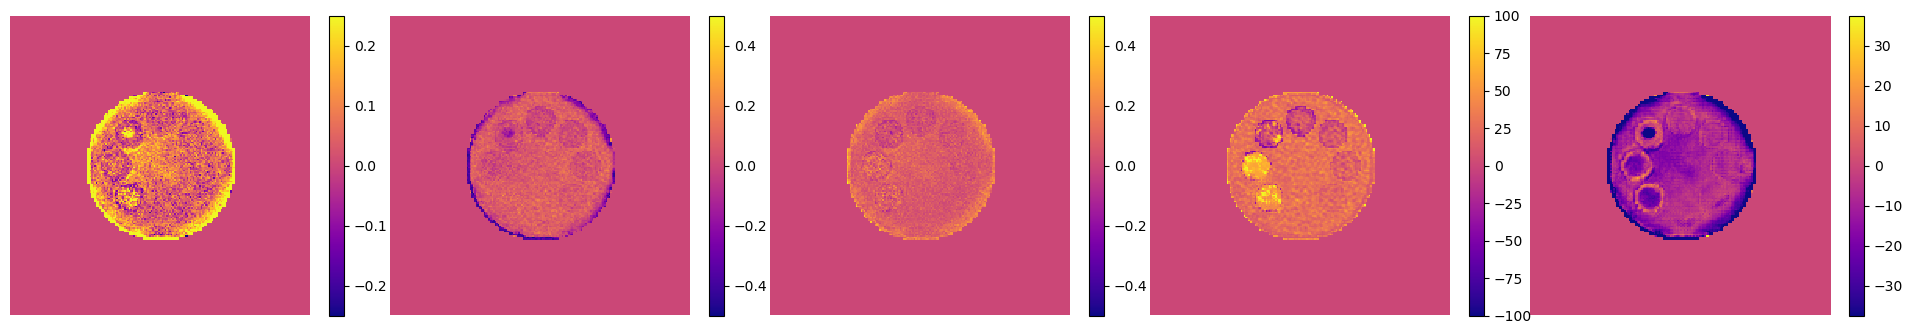

In [12]:
# DISPLAY ERROR (4 OUTPUTS)
fig_err, (ix0,ix1,ix2,ix3,ix4) = plt.subplots(figsize=(19, 3), nrows=1, ncols=5)

# Ground truth in the first row
ff_err = (PDFF_res-PDFF_gt)
FF_err = ix0.imshow(ff_err, cmap='plasma',
                    interpolation='none', vmin=-0.25, vmax=0.25)
fig_err.colorbar(FF_err, ax=ix0)
ix0.axis('off')

w_err = (w_aux-wn_aux)
Wn_err = ix1.imshow(w_err, cmap='plasma',
                    interpolation='none', vmin=-0.5, vmax=0.5)
fig_err.colorbar(Wn_err, ax=ix1)
# ix1.set_title('Water Error')
ix1.axis('off')
f_err = (f_aux-fn_aux)
Fn_err = ix2.imshow(f_err, cmap='plasma',
                    interpolation='none', vmin=-0.5, vmax=0.5)
fig_err.colorbar(Fn_err, ax=ix2)
# ix2.set_title('Fat Error')
ix2.axis('off')
r2_err = (r2_aux-r2n_aux)
r2n_err = ix3.imshow(r2_err, cmap='plasma',
                     interpolation='none', vmin=-r2_sc/2, vmax=r2_sc/2)
fig_err.colorbar(r2n_err, ax=ix3)
# ix3.set_title('R2* Error')
ix3.axis('off')
field_err = (field_aux-fieldn_aux)
fieldn_err = ix4.imshow(field_err, cmap='plasma',
                        interpolation='none', vmin=-fm_sc/8, vmax=fm_sc/8)
fig_err.colorbar(fieldn_err, ax=ix4)
# ix4.set_title('Field Error')
ix4.axis('off')

plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0.1,wspace=0)
plt.show()

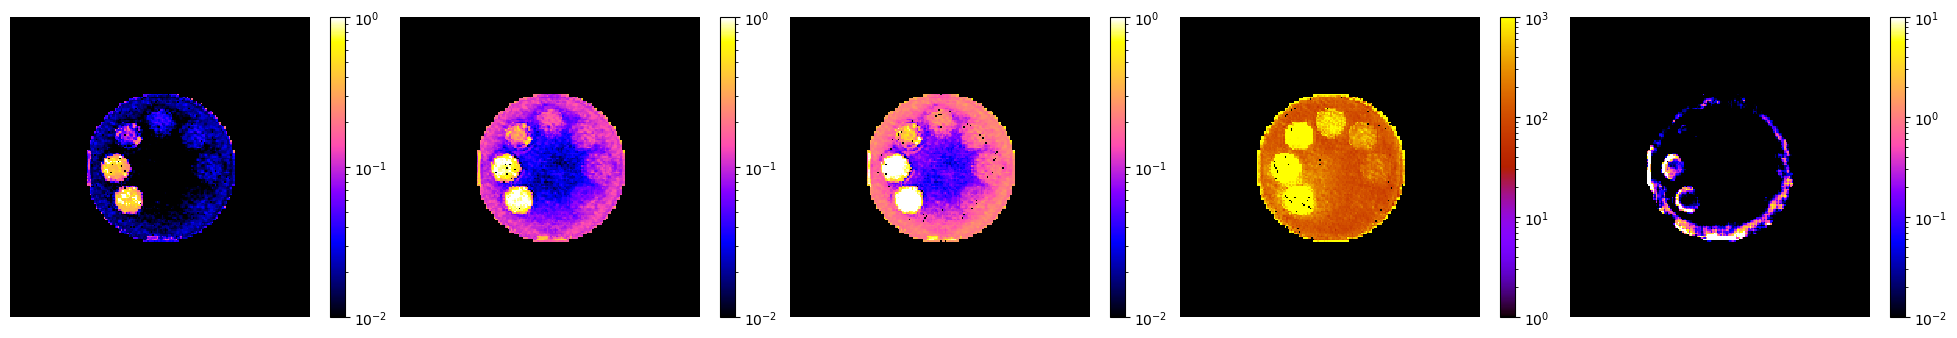

In [13]:
from matplotlib.colors import LogNorm

if A2B_var is not None: #bayesian
    # DISPLAY STD (4 OUTPUTS)
    fig_std, oxs = plt.subplots(figsize=(19.5, 3), nrows=1, ncols=5)

    WF_var = np.squeeze(A2B_var[:,2,:,:,0])
    WF_uq = oxs[0].matshow(WF_var, cmap='gnuplot2', norm=LogNorm(vmin=1e-2,vmax=1e0))
    fig_std.colorbar(WF_uq, ax=oxs[0])
    oxs[0].axis('off')

    W_var = np.squeeze(tf.abs(tf.complex(A2B_var[:,0,:,:,0],A2B_var[:,0,:,:,1])))
    W_uq = oxs[1].matshow(W_var, cmap='gnuplot2', norm=LogNorm(vmin=1e-2,vmax=1e0))
    fig_std.colorbar(W_uq, ax=oxs[1])
    oxs[1].axis('off')
    
    F_var = np.squeeze(tf.abs(tf.complex(A2B_var[:,3,:,:,0],A2B_var[:,3,:,:,1])))
    F_uq = oxs[2].matshow(F_var, cmap='gnuplot2', norm=LogNorm(vmin=1e-2,vmax=1e0))
    fig_std.colorbar(F_uq, ax=oxs[2])
    oxs[2].axis('off')

    # STDs in the two subplots
    r2s_var = np.squeeze(A2B_var[:,4,:,:,1])*(r2_sc**2)
    r2s_uq = oxs[3].matshow(r2s_var, cmap='gnuplot', norm=LogNorm(vmin=1e0,vmax=1e3))
    fig_std.colorbar(r2s_uq, ax=oxs[3])
    oxs[3].axis('off')
    field_var = np.squeeze(A2B_var[:,4,:,:,0])*(fm_sc**2)
    field_uq = oxs[4].matshow(field_var, cmap='gnuplot2', norm=LogNorm(vmin=1e-2,vmax=1e1))
    fig_std.colorbar(field_uq, ax=oxs[4])
    oxs[4].axis('off')

    plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0.1,wspace=0)
    plt.show()

(-0.5, 191.5, 191.5, -0.5)

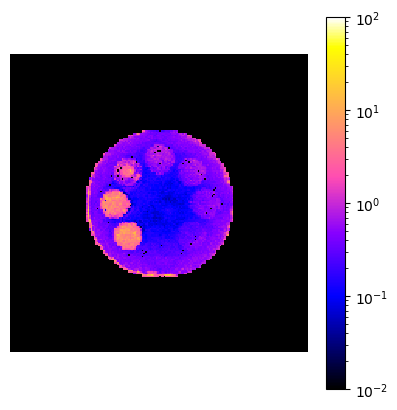

In [14]:
PDFF_var = F_var/(f_aux**2 + 1e-8)
PDFF_var -= 2 * WF_var / (f_aux*(w_aux+f_aux) + 1e-12)
PDFF_var += (W_var + F_var + 2*WF_var)/(w_aux + f_aux + 1e-12)
PDFF_var *= f_aux**2 / (w_aux+f_aux + 1e-6)**2 #[W_var,WF_var,F_var]
PDFF_var[PDFF_var<=0.0] = 1e-2

plt.matshow(PDFF_var, cmap='gnuplot2', norm=LogNorm(vmin=1e-2,vmax=1e2))
plt.colorbar()
plt.axis('off')

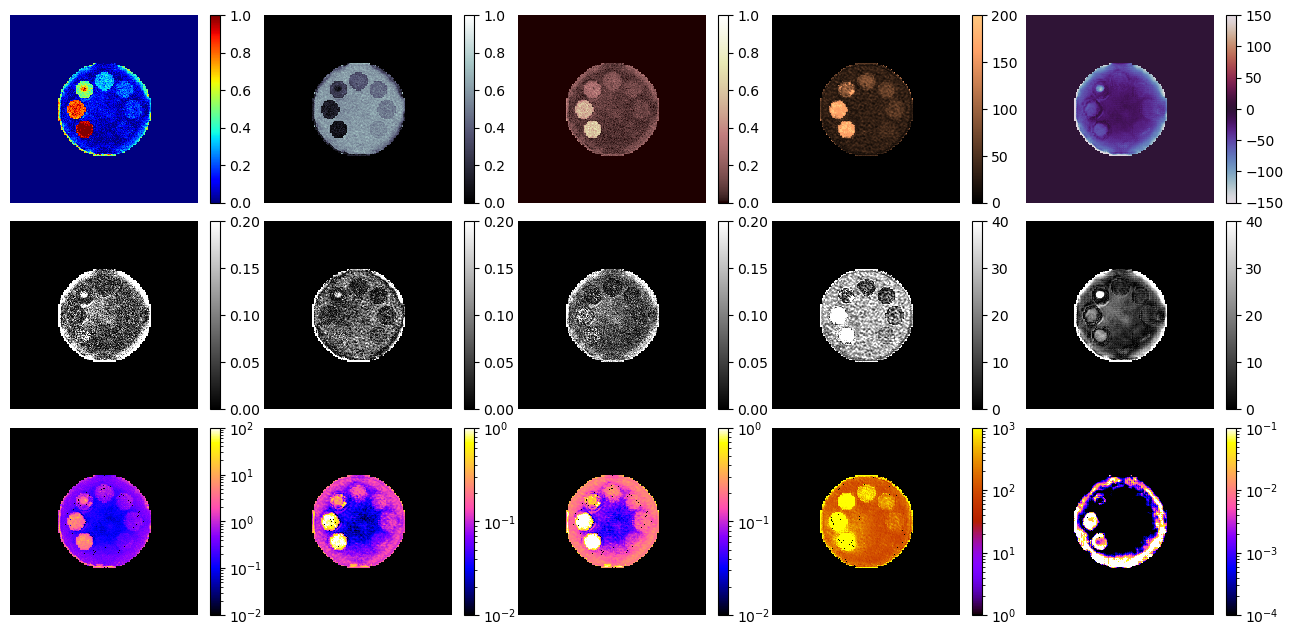

In [15]:
fig,axs=plt.subplots(figsize=(12.7, 6), nrows=3, ncols=5)

# Estimated maps in the first row
FF_ok = axs[0,0].imshow(PDFF_res, cmap='jet',
                        interpolation='none', vmin=0, vmax=1)
fig.colorbar(FF_ok, ax=axs[0,0])
axs[0,0].axis('off')
W_ok =  axs[0,1].imshow(w_aux, cmap='bone',
                        interpolation='none', vmin=0, vmax=1)
fig.colorbar(W_ok, ax=axs[0,1])
axs[0,1].axis('off')
F_ok =  axs[0,2].imshow(f_aux, cmap='pink',
                        interpolation='none', vmin=0, vmax=1)
fig.colorbar(F_ok, ax=axs[0,2])
axs[0,2].axis('off')
r2_ok = axs[0,3].imshow(r2_aux, cmap='copper',
                        interpolation='none', vmin=0, vmax=r2_sc)
fig.colorbar(r2_ok, ax=axs[0,3])
axs[0,3].axis('off')
field_ok =  axs[0,4].imshow(field_aux, cmap='twilight',
                            interpolation='none', vmin=-fm_sc/2, vmax=fm_sc/2)
fig.colorbar(field_ok, ax=axs[0,4])
axs[0,4].axis('off')

# Abs. error in the second row
FF_est =axs[1,0].imshow(np.abs(PDFF_res-PDFF_gt), cmap='gray',
                        interpolation='none', vmin=0, vmax=0.2)
fig.colorbar(FF_est, ax=axs[1,0])
axs[1,0].axis('off')
W_est = axs[1,1].imshow(np.abs(w_aux-wn_aux), cmap='gray',
                        interpolation='none', vmin=0, vmax=0.2)
fig.colorbar(W_est, ax=axs[1,1])
axs[1,1].axis('off')

F_est = axs[1,2].imshow(np.abs(f_aux-fn_aux), cmap='gray',
                        interpolation='none', vmin=0, vmax=0.2)
fig.colorbar(F_est, ax=axs[1,2])
axs[1,2].axis('off')

r2_est= axs[1,3].imshow(np.abs(r2_aux-r2n_aux), cmap='gray',
                        interpolation='none', vmin=0.0, vmax=r2_sc/5)
fig.colorbar(r2_est, ax=axs[1,3])
axs[1,3].axis('off')

field_est = axs[1,4].imshow(np.abs(field_aux-fieldn_aux), cmap='gray',
                            interpolation='none', vmin=0.0, vmax=r2_sc/5)
fig.colorbar(field_est, ax=axs[1,4])
axs[1,4].axis('off')

# Uncertainty maps in the third row
WF_uq = axs[2,0].matshow(PDFF_var, cmap='gnuplot2',
                         norm=LogNorm(vmin=1e-2,vmax=1e2))
fig.colorbar(WF_uq, ax=axs[2,0])
axs[2,0].axis('off')
W_uq = axs[2,1].matshow(W_var, cmap='gnuplot2',
                        norm=LogNorm(vmin=1e-2,vmax=1e0))
fig.colorbar(W_uq, ax=axs[2,1])
axs[2,1].axis('off')
F_uq = axs[2,2].matshow(F_var, cmap='gnuplot2',
                        norm=LogNorm(vmin=1e-2,vmax=1e0))
fig.colorbar(F_uq, ax=axs[2,2])
axs[2,2].axis('off')
r2s_uq=axs[2,3].matshow(r2s_var, cmap='gnuplot',
                        norm=LogNorm(vmin=1e0,vmax=1e3))
fig.colorbar(r2s_uq, ax=axs[2,3])
axs[2,3].axis('off')
field_uq = axs[2,4].matshow(field_var, cmap='gnuplot2',
                            norm=LogNorm(vmin=1e-4,vmax=1e-1))
fig.colorbar(field_uq, ax=axs[2,4])
axs[2,4].axis('off')

plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0.1,wspace=0)
tl.make_space_above(axs,topmargin=0.6)

In [16]:
MAE_w = np.mean(tf.abs(w_aux-wn_aux), axis=(0,1))
MAE_f = np.mean(tf.abs(f_aux-fn_aux), axis=(0,1))
MAE_r2 = np.mean(tf.abs(r2_aux-r2n_aux), axis=(0,1))
MAE_fm = np.mean(tf.abs(field_aux-fieldn_aux), axis=(0,1))
print('MAEs:',np.round([MAE_w,MAE_f,MAE_r2,MAE_fm],5))
print('R2* MAE [1/s]:',np.round(MAE_r2,5))
print('Field Map MAE [Hz]:',np.round(MAE_fm,5))

MAEs: [0.01627 0.01689 5.70027 3.20733]
R2* MAE [1/s]: 5.70027
Field Map MAE [Hz]: 3.20733


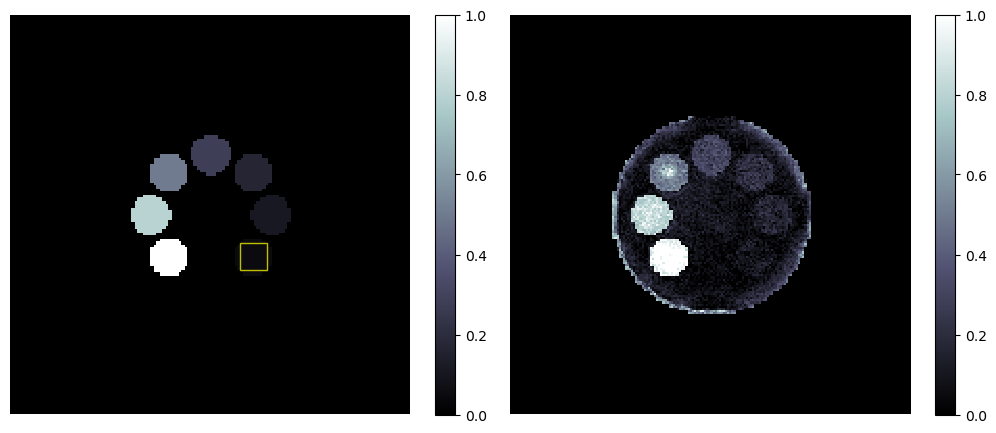

In [17]:
# Segmentation rectangle (ref. values for test data N°105)
verts_list = {1:   (69,109),#ok
              2:   (61,89),#ok
              3:   (69,68),#ok
              4:   (90,60),#ok
              5:  (110,68),#ok
              6:  (119,89),#ok
              7:  (110,109)}#ok

left_x,sup_y = verts_list[7]
rect_hgt,rect_wdt = 13,13
rect_gt = patches.Rectangle((left_x,sup_y),rect_wdt,rect_hgt,
                            linewidth=1,edgecolor='y',facecolor='none')
rect_res = patches.Rectangle((left_x,sup_y),rect_wdt,rect_hgt,
                             linewidth=1,edgecolor='r',facecolor='none')

fig_pdff, (ex1,ex2) = plt.subplots(figsize=(10, 4), nrows=1, ncols=2)

disp_pdff_ok = ex1.imshow(PDFF_gt, cmap='bone',
                          interpolation='none', vmin=0, vmax=1)
fig_pdff.colorbar(disp_pdff_ok, ax=ex1)
# ex1.set_title('PDFF Ground Truth',{'fontsize':15})
ex1.add_patch(rect_gt)
ex1.axis('off')

disp_pdff_res = ex2.imshow(PDFF_res, cmap='bone',
                           interpolation='none', vmin=0, vmax=1)
fig_pdff.colorbar(disp_pdff_res, ax=ex2)
# ex2.set_title('Resulting PDFF',{'fontsize':15})
# ex2.add_patch(rect_res)
ex2.axis('off')

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0.1, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

In [18]:
r1,r2 = sup_y,(sup_y+rect_hgt)
c1,c2 = left_x,(left_x+rect_wdt)
PDFF_gt_crop = PDFF_gt[r1:r2,c1:c2]
PDFF_res_crop = PDFF_res[r1:r2,c1:c2]

print('Median of PDFF in the segmented region:')
print('Ground-Truth:\t',np.median(PDFF_gt_crop))
print('Model result:\t',np.median(PDFF_res_crop))

Median of PDFF in the segmented region:
Ground-Truth:	 0.051999997
Model result:	 0.091608346


In [19]:
PDFF_res_all = list()
PDFF_err_list = list()
PDFF_iqr_all = list()
PDFF_gt_all = list()
rect_hgt,rect_wdt = 13,13
for k in verts_list:
    left_x,sup_y = verts_list[k]
    r1,r2 = sup_y,(sup_y+rect_hgt)
    c1,c2 = left_x,(left_x+rect_wdt)
    # PDFF crops - magnitude model results
    # w_all = all_test_ans[(k_prev+4):(k-4),r1:r2,c1:c2,0]
    # f_all = all_test_ans[(k_prev+4):(k-4),r1:r2,c1:c2,1]
    # PDFF crops - complex model results
    w_all = w_aux[r1:r2,c1:c2]
    f_all = f_aux[r1:r2,c1:c2]
    wf_all = wf_aux[r1:r2,c1:c2]
    PDFF_res = np.where(f_all>=w_all, f_all/wf_all, 1-w_all/wf_all)
    PDFF_res_aux = np.median(PDFF_res)
    PDFF_res_all.append(PDFF_res_aux)
    # PDFF crops - GT magnitude results
    # w_all_gt = testY[(k_prev+4):(k-4):,r1:r2,c1:c2,0]
    # f_all_gt = testY[(k_prev+4):(k-4),r1:r2,c1:c2,1]
    # PDFF crops - GT complex results
    w_all_gt = wn_aux[r1:r2,c1:c2]
    f_all_gt = fn_aux[r1:r2,c1:c2]
    PDFF_gt = f_all_gt/(f_all_gt+w_all_gt)
    PDFF_gt_aux = np.median(PDFF_gt)
    PDFF_gt_all.append(PDFF_gt_aux)
    PDFF_err = np.median(np.abs(PDFF_res-PDFF_gt))
    PDFF_err_list.append(PDFF_err)
    PDFF_iqr_aux_low = np.quantile(np.abs(PDFF_res-PDFF_gt),0.25)
    PDFF_iqr_aux_high= np.quantile(np.abs(PDFF_res-PDFF_gt),0.75)
    PDFF_iqr_all.append([PDFF_err-PDFF_iqr_aux_low,PDFF_iqr_aux_high-PDFF_err])

# Compute error
PDFF_err_list_disp = np.array(PDFF_res_all)-np.array(PDFF_gt_all)
print('PDFF estimations:',np.round(PDFF_res_all,5))
print('Ground-truth:',np.round(PDFF_gt_all,5))
print('Errors:',np.round(PDFF_err_list_disp,5))

# PDFF crops mean error
PDFF_err_mean = np.mean((PDFF_err_list))
PDFF_err_std = np.std((PDFF_err_list))
print('Mean PDFF error:',np.round(PDFF_err_mean*100,2),
      '+-',np.round(PDFF_err_std*100,2),'%')

PDFF estimations: [1.0868  0.83413 0.53281 0.30779 0.21459 0.16626 0.09161]
Ground-truth: [1.    0.8   0.5   0.28  0.171 0.113 0.052]
Errors: [0.0868  0.03413 0.03281 0.02779 0.04359 0.05326 0.03961]
Mean PDFF error: 5.81 +- 1.76 %


In [20]:
r2_res_all = list()
r2_gt_all = list()
for k in verts_list:
    left_x,sup_y = verts_list[k]
    r1,r2 = sup_y,(sup_y+rect_hgt)
    c1,c2 = left_x,(left_x+rect_wdt)
    # R2* crops - complex model results
    r2_all = r2_aux[r1:r2,c1:c2]
    r2_res_aux = np.mean(r2_all)
    r2_res_all.append(r2_res_aux)
    # R2* crops - GT complex results
    r2_all_gt = r2n_aux[r1:r2,c1:c2]
    r2_gt_aux = np.mean(r2_all_gt)
    r2_gt_all.append(r2_gt_aux)

# Compute error
r2_err_list = np.array(r2_res_all)-np.array(r2_gt_all)
print('R2* estimations:',r2_res_all)
print('Ground-truth:',r2_gt_all)
print('Errors:\\n',r2_err_list)

# R2* crops mean error
r2_err_mean = np.mean((r2_err_list))
r2_err_std = np.std((r2_err_list))
print('Mean R2* error:',np.round(r2_err_mean,2),
      '+-',np.round(r2_err_std,2),'[1/s]')

R2* estimations: [177.2364, 172.48338, 93.214645, 73.455635, 60.342957, 53.956963, 41.741238]
Ground-truth: [116.294266, 100.73673, 83.053375, 68.655464, 50.875473, 35.801132, 19.470604]
Errors:\n [60.94214   71.74665   10.16127    4.800171   9.4674835 18.15583
 22.270634 ]
Mean R2* error: 28.22 +- 24.87 [1/s]


In [21]:
fuq_res_all = list()
for k in verts_list:
    left_x,sup_y = verts_list[k]
    r1,r2 = sup_y,(sup_y+rect_hgt)
    c1,c2 = left_x,(left_x+rect_wdt)
    # R2* crops - complex model results
    w_all = w_aux[r1:r2,c1:c2]
    f_all = f_aux[r1:r2,c1:c2]
    wf_all = wf_aux[r1:r2,c1:c2]
    wuq_all = W_var[r1:r2,c1:c2]
    fuq_all = F_var[r1:r2,c1:c2]
    wfuq_all = WF_var[r1:r2,c1:c2]
    # fuq_sc_all = wuq_all + fuq_all + 2*wfuq_all #/(fim_all**2)
    aux_all = w_all#np.where(f_all>=w_all, f_all, w_all)
    aux_uq_all = wuq_all#np.where(f_all>=w_all, fuq_all, wuq_all)
    fuq_sc_all = aux_uq_all/(aux_all**2)
    fuq_sc_all -= 2 * wfuq_all / (aux_all*wf_all)
    fuq_sc_all += (wuq_all + fuq_all + 2*wfuq_all) / wf_all
    fuq_sc_all *= aux_all**2 / wf_all**2
    fuq_res_aux = np.mean(fuq_sc_all)
    fuq_res_all.append(np.sqrt(fuq_res_aux))
    
# Display uncertainties
print('Fat-only uncertainties:',fuq_res_all)

Fat-only uncertainties: [1.8397593, 1.5113928, 1.1030132, 0.794306, 0.7655417, 0.7231391, 0.6456128]


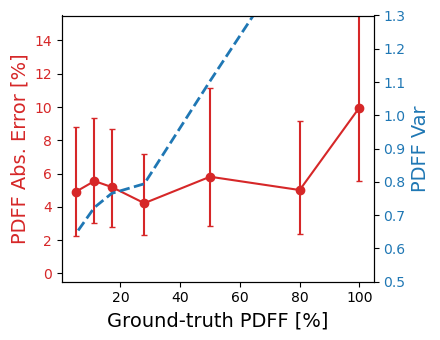

In [22]:
fig, ax1 = plt.subplots(figsize=(4.5,3.5))

color = 'tab:red'
ax1.set_xlabel('Ground-truth PDFF [%]', fontsize=14)
ax1.set_ylabel('PDFF Abs. Error [%]', color=color, fontsize=14)
ax1.errorbar(100.0*np.round(PDFF_gt_all,4), 100.0*np.round(PDFF_err_list,4),
             100.0*np.round(np.transpose(PDFF_iqr_all),4), marker='o', color=color, capsize=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-0.5,15.5)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('PDFF Var', color=color, fontsize=14)  # we already handled the x-label with ax1
ax2.plot(100.0*np.round(PDFF_gt_all,4), fuq_res_all, color=color, linestyle='--', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0.5,1.3)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()